# Miller age

In [1]:
1

1

In [2]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [169]:
ood_seed = 1
num_ood = 1

In [170]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect();

In [171]:
df = adata.obs.groupby(["condition", "dose"]).size()
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [172]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 350]
    rng = np.random.default_rng(seed=seed)
    random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    choices = [availables[i] for i in random_choices]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Nutlin', '0.5'), 359)

Removed datapoint: 359


In [173]:
adata

AnnData object with n_obs × n_vars = 14452 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [174]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_ood-seed-{ood_seed}_size-{num_ood}"
)

In [175]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [176]:
warmup_epoch_range = [0, 12]
# _, n_epochs_kl_warmup = warmup_epoch_range
n_epochs_kl_warmup = 600

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

tardis_loss_weight_1 = 100
tardis_loss_weight_2 = 10

disentenglement_targets_configurations=[
    dict(
        obs_key = "dose_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                # target_type="pseudo_categorical",
                # non_categorical_coefficient_method="squared_difference",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            # dict(
            #     apply = True, 
            #     target_type="categorical",
            #     progress_bar = True,
            #     weight = tardis_loss_weight_1,
            #     method = "mse_z", 
            #     latent_group = "unreserved",
            #     counteractive_example = "negative",
            #     transformation = "none", 
            #     warmup_epoch_range=warmup_epoch_range,
            #     method_kwargs = {}
            # ),
            # dict(
            #     apply = True, 
            #     target_type="categorical",
            #     progress_bar = True,
            #     weight = tardis_loss_weight_2, 
            #     method = "mse_z", 
            #     latent_group = "unreserved",
            #     counteractive_example = "positive",
            #     transformation = "inverse",
            #     warmup_epoch_range=warmup_epoch_range,
            #     method_kwargs = {}
            # ),
        ]
    ),
    # dict(
    #     obs_key = "condition",
    #     n_reserved_latent = 8,
    #     counteractive_minibatch_settings = counteractive_minibatch_settings,
    #     auxillary_losses = [
    #         dict(
    #             apply = True, 
    #             target_type="categorical",
    #             progress_bar = True,
    #             weight = tardis_loss_weight_1,
    #             method = "mse_z", 
    #             latent_group = "reserved",
    #             counteractive_example = "negative",
    #             transformation = "inverse", 
    #             warmup_epoch_range=warmup_epoch_range,
    #             method_kwargs = {}
    #         ),
    #         dict(
    #             apply = True, 
    #             target_type="categorical",
    #             progress_bar = True,
    #             weight = tardis_loss_weight_2, 
    #             method = "mse_z", 
    #             latent_group = "reserved",
    #             counteractive_example = "positive",
    #             transformation = "none",
    #             warmup_epoch_range=warmup_epoch_range,
    #             method_kwargs = {}
    #         ),
    #         # dict(
    #         #     apply = True, 
    #         #     target_type="categorical",
    #         #     progress_bar = True,
    #         #     weight = tardis_loss_weight_1,
    #         #     method = "mse_z", 
    #         #     latent_group = "unreserved",
    #         #     counteractive_example = "negative",
    #         #     transformation = "none", 
    #         #     warmup_epoch_range=warmup_epoch_range,
    #         #     method_kwargs = {}
    #         # ),
    #         # dict(
    #         #     apply = True, 
    #         #     target_type="categorical",
    #         #     progress_bar = True,
    #         #     weight = tardis_loss_weight_2, 
    #         #     method = "mse_z", 
    #         #     latent_group = "unreserved",
    #         #     counteractive_example = "positive",
    #         #     transformation = "inverse",
    #         #     warmup_epoch_range=warmup_epoch_range,
    #         #     method_kwargs = {}
    #         # ),
    #     ]
    # )
]

model_params = dict(
    n_hidden=128,
    n_layers=2, 
    n_latent=40, 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.2,
    include_auxillary_loss = True
)

train_params = dict(
    max_epochs=600,
    train_size=0.7,
    batch_size=512,
    check_val_every_n_epoch=10,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-3,
        weight_decay=1e-3,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    ),
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations
)

tardis.MyModel.setup_anndata(adata, **dataset_params)

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata, 
    deeply_inject_disentengled_latents=True, 
    encode_covariates=True,
    beta_kl_weight=.25,
    **model_params
)
vae.train(**train_params)

# vae.save(
#     dir_path,
#     overwrite=True,
# )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-d7527232-b423-53a6-b24b-0b680aeec10f,MIG-16007a59-529c-5576-835b-d41589ac37ab]
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/600:   0%|                                                                                                                              | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1533,1371,983,1507,1267,1336,1244,876
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 622,590,450,664,523,604,523,359
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 600/600: 100%|█| 600/600 [10:16<00:00,  1.02s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, tardis_dose_training_0_train=20, tardis_dose_training_1_

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|█| 600/600 [10:16<00:00,  1.03s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, tardis_dose_training_0_train=20, tardis_dose_training_1_


In [177]:
vae.get_MI_normalized_training("dose_training")

{('validation', 'reserved'): 0.2686378556130087,
 ('validation', 'unreserved'): 0.1408136247758135,
 ('train', 'reserved'): 0.7558882175178332,
 ('train', 'unreserved'): 0.10229171541761156}

In [179]:
vae.get_MI_normalized_training("condition")

In [180]:
vae.get_knn_purity_training("dose_training")

{('validation', 'reserved'): 0.3176821368421283,
 ('validation', 'unreserved'): 0.35728212113730373,
 ('train', 'reserved'): 0.9436428738977353,
 ('train', 'unreserved'): 0.5325554386977823}

In [181]:
vae.get_knn_purity_training("condition")

In [182]:
vae.get_get_reconstruction_r2_training(top_n=[], batch_size=128)

{('validation', 'total'): 0.9969721609217804,
 ('train', 'total'): 0.9963003428017678}

In [183]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)

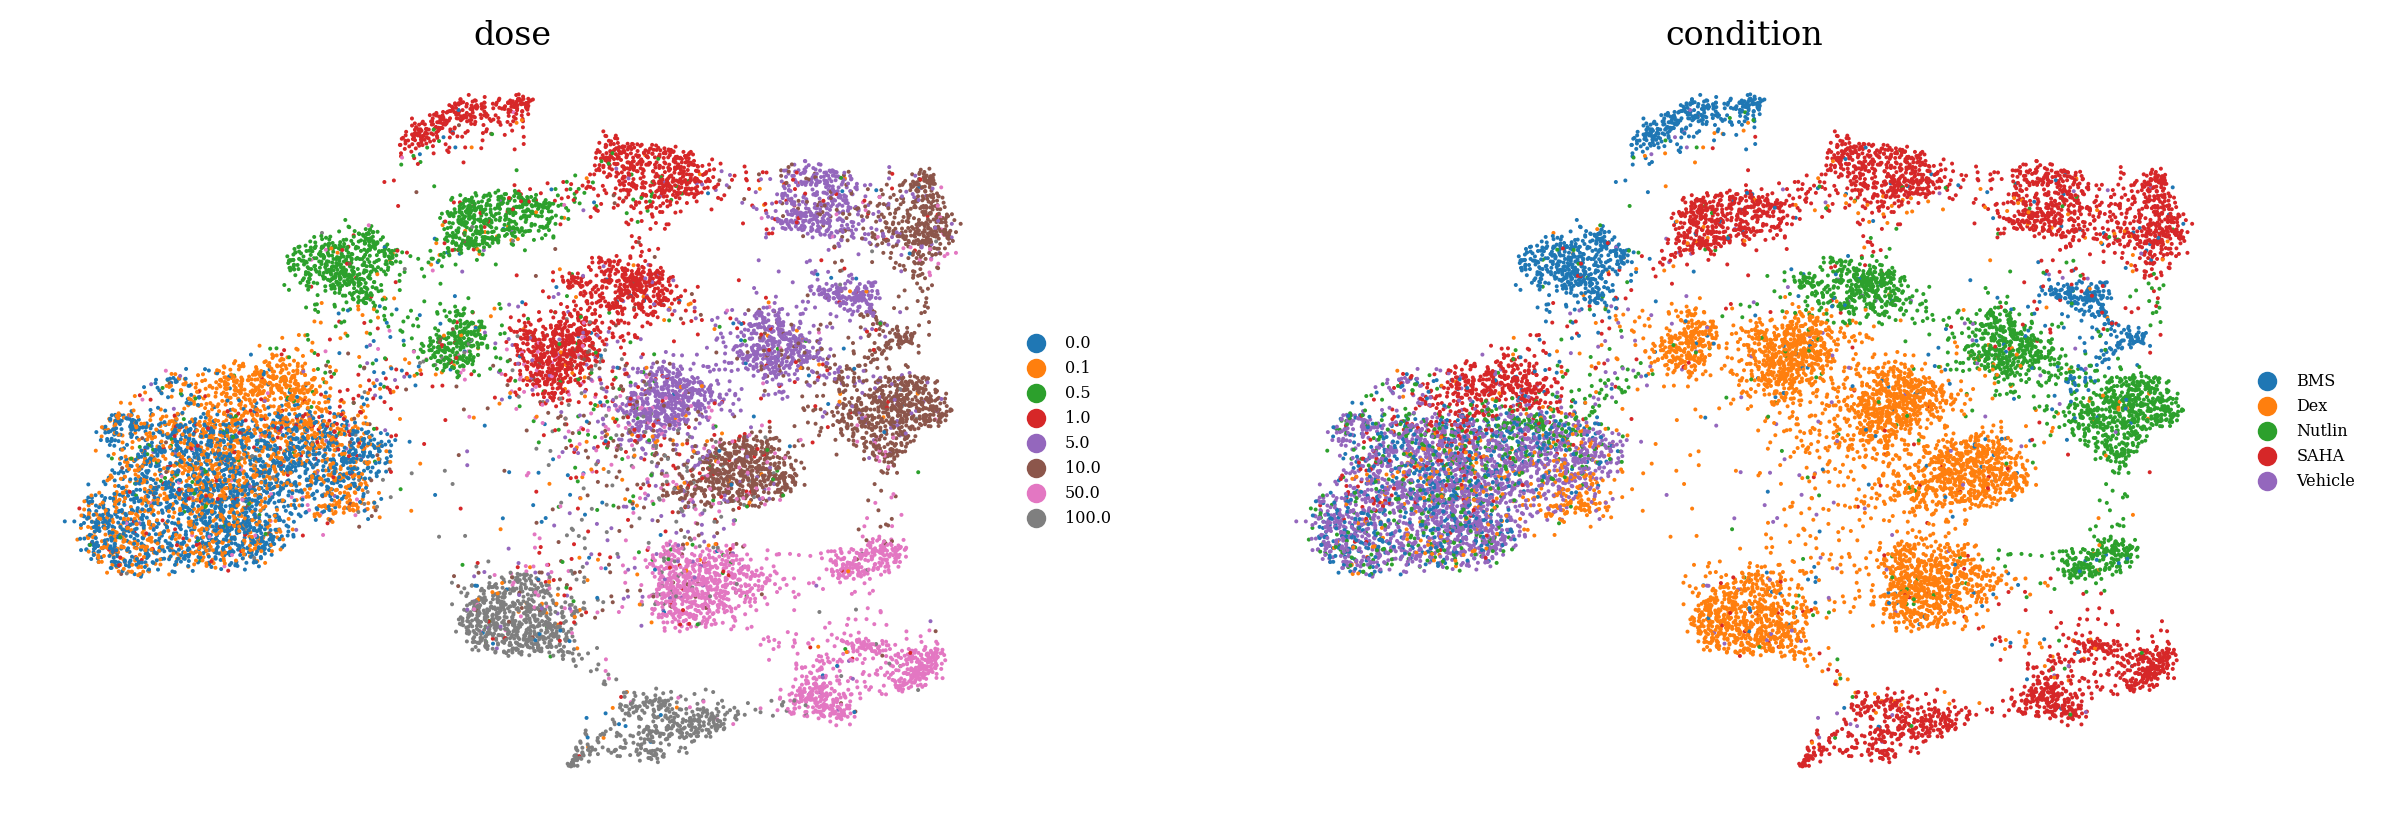

In [184]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [185]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [ ]:
indices=vae.validation_indices
latent = ad.AnnData(X=vae.get_latent_representation(indices=indices)[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.iloc[indices].copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [ ]:
indices=vae.train_indices
latent = ad.AnnData(X=vae.get_latent_representation(indices=indices)[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.iloc[indices].copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

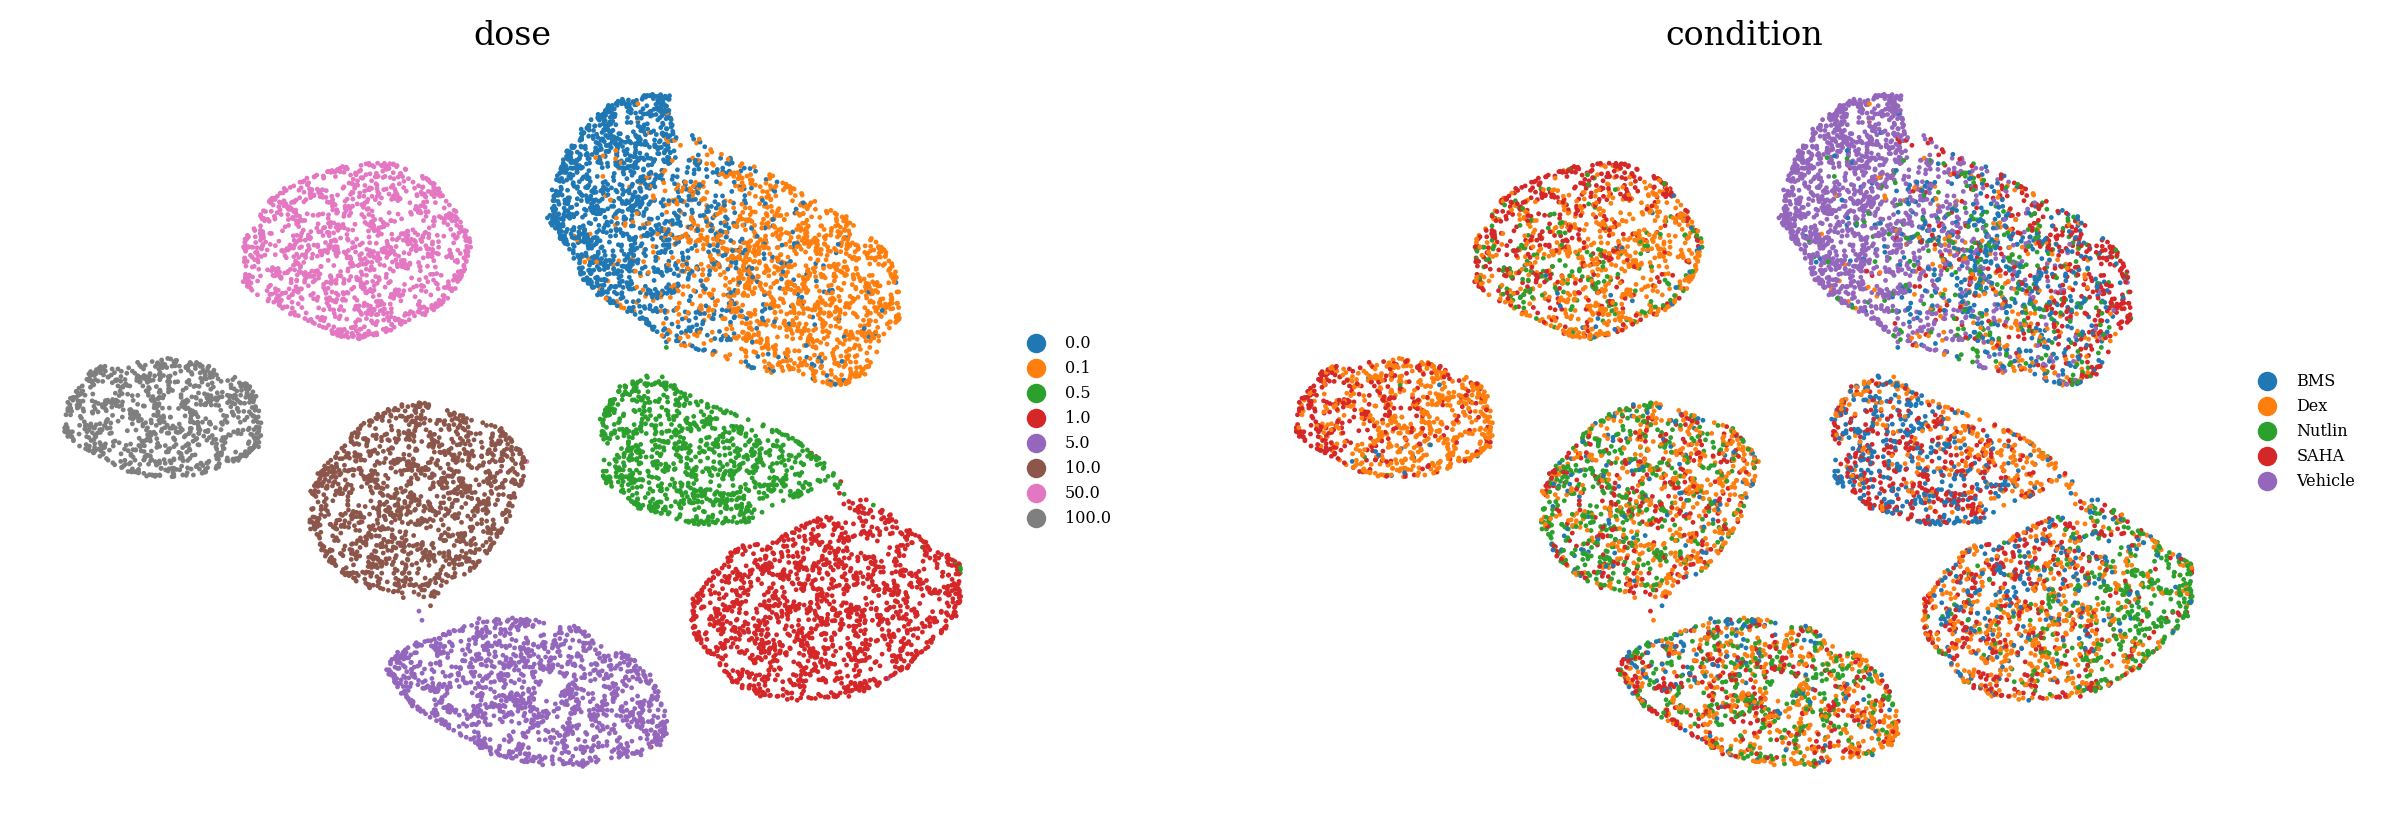

In [186]:
indices=vae.train_indices
latent = ad.AnnData(X=vae.get_latent_representation(indices=indices)[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.iloc[indices].copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

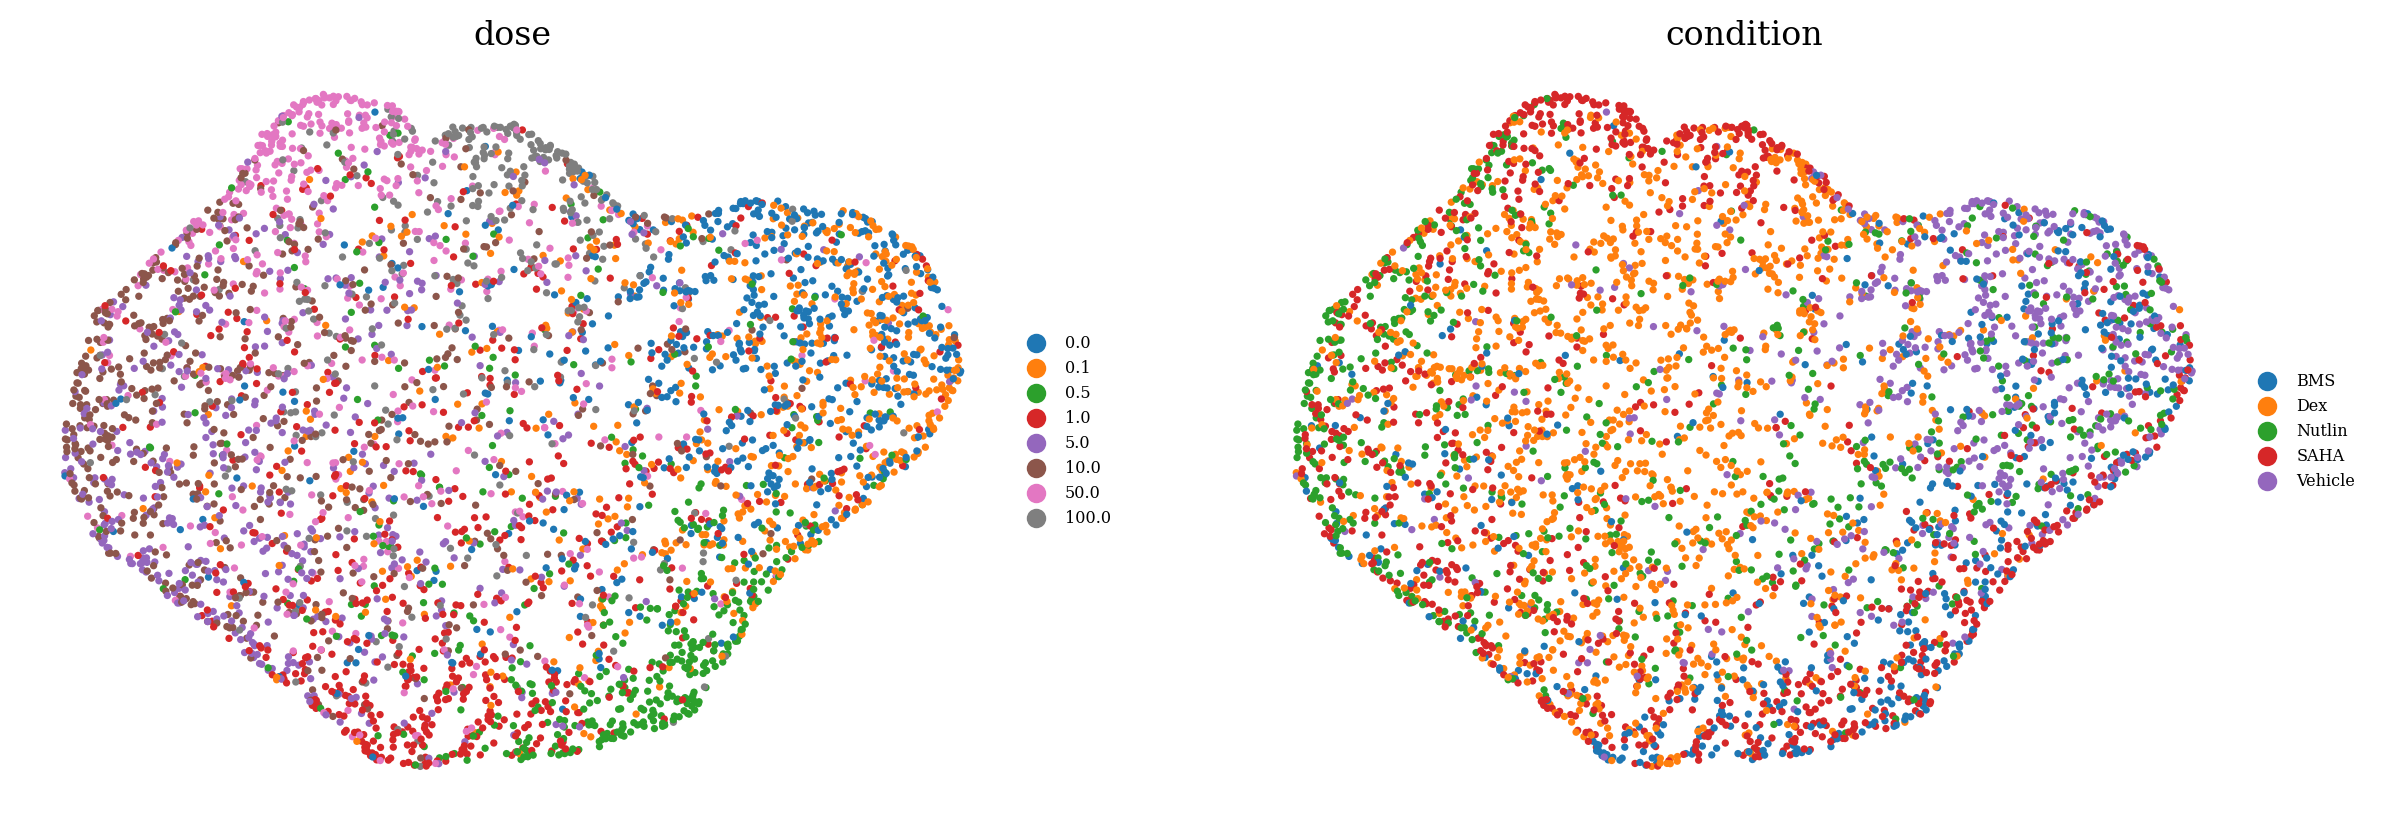

In [187]:
indices=vae.validation_indices
latent = ad.AnnData(X=vae.get_latent_representation(indices=indices)[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.iloc[indices].copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [188]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.X = adata_main.layers["counts"].copy()
del adata_main.layers
adata.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]
gc.collect();
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [189]:
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood, n_neighbors = 30)
sc.tl.umap(latent_ood)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [190]:
from scanpy.tools import Ingest as sc_Ingest

def label_transfer(
    reference_embeddings: ad.AnnData,
    query_embeddings: ad.AnnData,
    cluster_list: list[str],
    neighbors_count: int,
):
    # Compute a joint neighbor graph for reference and query embeddings
    joint_graph = sc_Ingest(reference_embeddings)
    joint_graph.fit(query_embeddings)
    joint_graph.neighbors(k=neighbors_count)

    # Calculate distances to top neighbors_count neighbors for each cell and store indices
    top_neighbor_distances, top_neighbor_indices = joint_graph._distances, joint_graph._indices

    # Transform distances with Gaussian kernel
    distance_stds = np.std(top_neighbor_distances, axis=1)
    distance_stds = (2.0 / distance_stds) ** 2
    distance_stds = distance_stds.reshape(-1, 1)
    transformed_distances = np.exp(-np.true_divide(top_neighbor_distances, distance_stds))

    # Normalize transformed distances so that they sum to 1
    normalized_weights = transformed_distances / np.sum(transformed_distances, axis=1, keepdims=True)

    # Initialize empty series to store predicted labels and uncertainties for each query cell
    cell_uncertainties = pd.Series(index=query_embeddings.obs_names, dtype="float64")
    predicted_labels = pd.Series(index=query_embeddings.obs_names, dtype="object")

    # Iterate through query cells
    for cluster in cluster_list:
        train_labels = reference_embeddings.obs[cluster].values
        for index in range(len(normalized_weights)):
            # Store cell types present among neighbors in reference
            unique_cell_types = np.unique(train_labels[top_neighbor_indices[index]])

            # Store best label and corresponding probability
            best_cell_type, best_probability = None, 0.0

            # Iterate through all cell types present among the cell's neighbors
            for label in unique_cell_types:
                prob = normalized_weights[index, train_labels[top_neighbor_indices[index]] == label].sum()
                if best_probability < prob:
                    best_probability = prob
                    best_cell_type = label
            else:
                final_label = best_cell_type

            # Store best label and corresponding uncertainty
            cell_uncertainties.iloc[index] = max(1 - best_probability, 0)
            predicted_labels.iloc[index] = final_label

        query_embeddings.obs[f"transf_{cluster}"] = predicted_labels
        query_embeddings.obs[f"transf_{cluster}_unc"] = cell_uncertainties

In [191]:
label_transfer(latent, latent_ood, cluster_list=["dose_training"], neighbors_count=30)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [192]:
target = "dose_training"

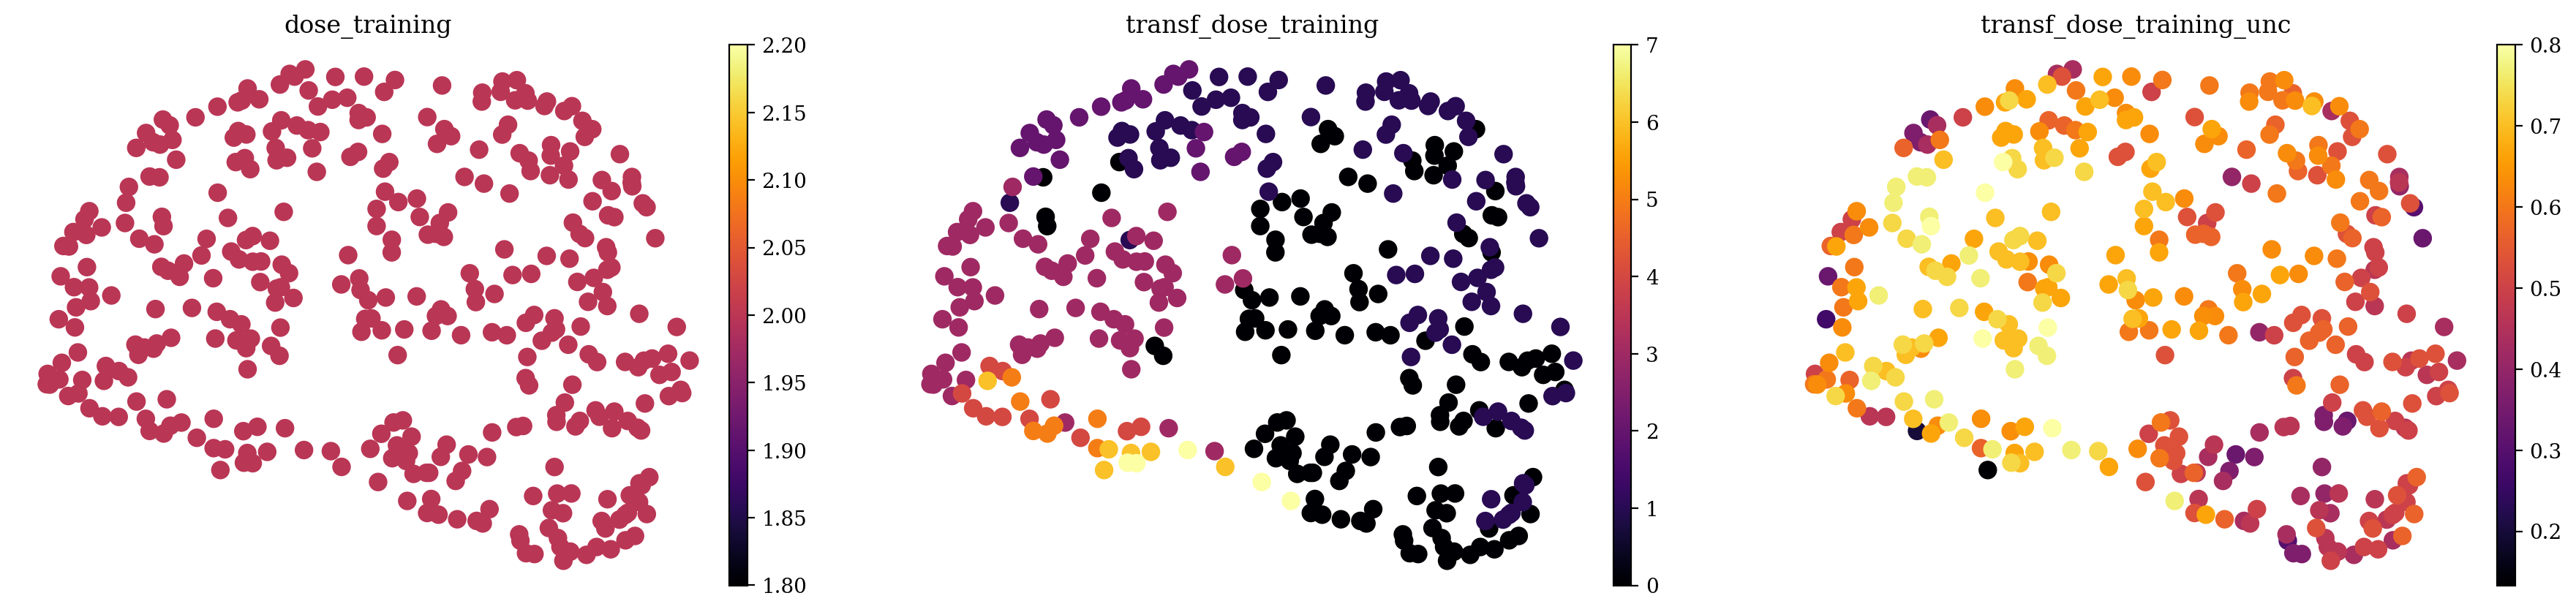

In [193]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[target, f"transf_{target}", f"transf_{target}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [194]:
latent_ood

AnnData object with n_obs × n_vars = 359 × 8
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training', 'ood', '_scvi_batch', '_scvi_labels', 'transf_dose_training', 'transf_dose_training_unc'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [195]:
k="dose_training"

In [196]:
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

In [197]:
(predicted == true).sum() / len(true) 

0.06685236768802229

In [198]:
import sklearn

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

In [199]:
metrics

{'accuracy': 0.06685236768802229,
 'precision_macro': 0.125,
 'recall_macro': 0.008356545961002786,
 'f1_score_macro': 0.015665796344647518,
 'precision_micro': 0.06685236768802229,
 'recall_micro': 0.06685236768802229,
 'f1_score_micro': 0.06685236768802229,
 'precision_weighted': 1.0,
 'recall_weighted': 0.06685236768802229,
 'f1_score_weighted': 0.12532637075718014,
 'confusion_matrix': array([[  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [135,  98,  24,  73,  11,   7,   6,   5],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]])}